In [30]:
from generate_samples import SyntheticDAG
import torch
import matplotlib.pyplot as plt

from models.causal_peeler_oracle import identify
from models.noise_estimator import estimate_noise

from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
def sample_full_rank_matrix(n=3, lower=-10, upper=10):
    while True:
        matrix = torch.FloatTensor(n, n).uniform_(lower, upper)
        matrix.requires_grad_(True)
        matrix.retain_grad()
        if torch.det(matrix).item() != 0:
            return matrix

In [3]:
DAG_type = 'line'
num_latent = 4
G = sample_full_rank_matrix(num_latent, -1, 1)+torch.eye(num_latent)

In [4]:
graph = SyntheticDAG(num_latent, DAG_type)

In [6]:
U,X,noises = graph.sample_scaled(G, 4000)

In [7]:
U_estimates, layers = identify(graph, U, G)

-----------------------------------------------------------
Removing Layer 0.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-04-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-04-12


Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found:
[-0.07290772  0.32790282 -0.24839552  0.90855042]

No feasible solution found.
Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 1.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found:
[-0.52714683  0.79479202 -0.30070227]

No feasible solution found.
Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 2.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found:
[-0.88284726  0.46966022]

No feasible solution found.
Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 3.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Peeled off 1 nodes.


In [8]:
layers

[[0], [1], [2], [3]]

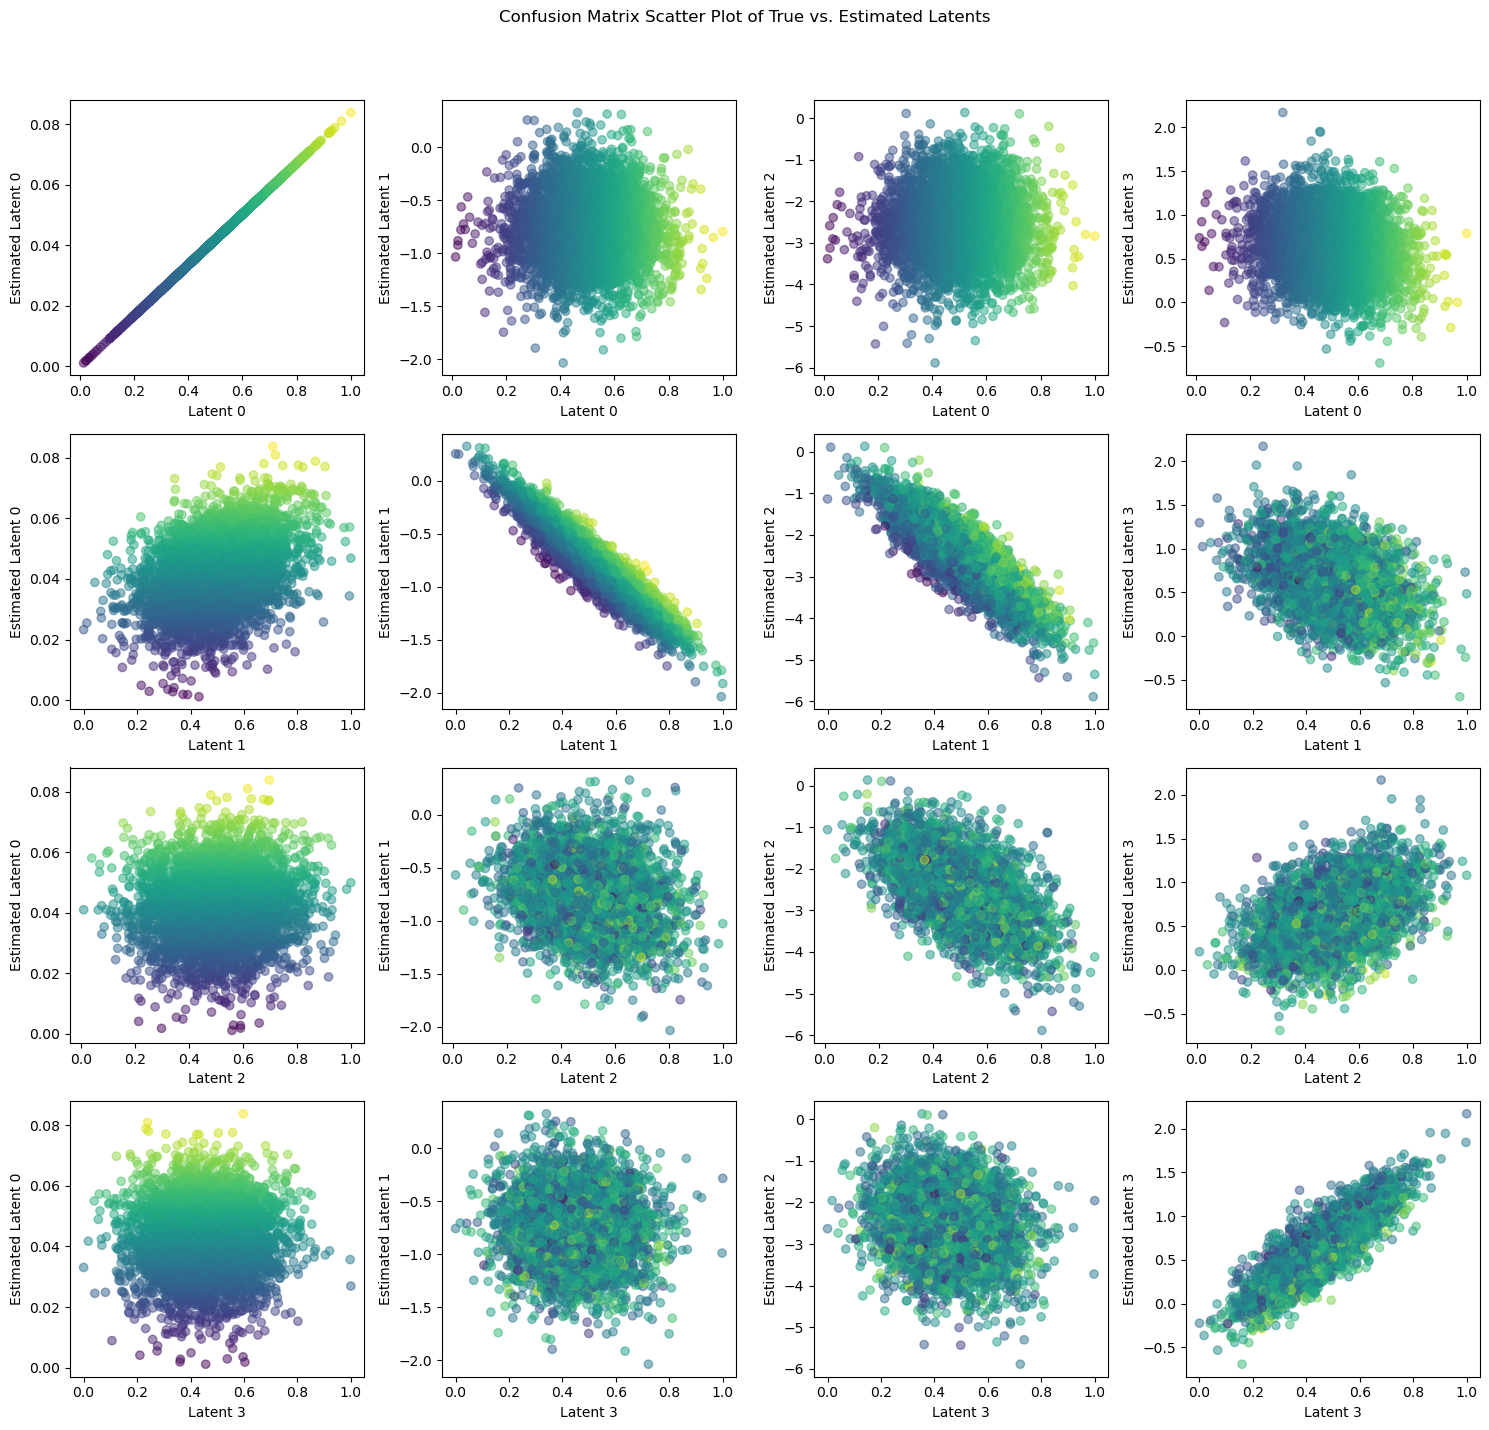

In [15]:
U_np = U.detach().numpy()
fig, axes = plt.subplots(nrows=num_latent, ncols=num_latent, figsize=(15, 15))
fig.suptitle('Confusion Matrix Scatter Plot of True vs. Estimated Latents')

for i in range(num_latent):
    for j in range(num_latent):
        ax = axes[i, j]
        ax.scatter(U_np[:, i], U_estimates[:, j], alpha=0.5,  c = U_np[:,0])
        ax.set_xlabel(f'Latent {i}')
        ax.set_ylabel(f'Estimated Latent {j}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [34]:
def MLPRegressorInstance():
    return MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)

def SVRInstance():
    return SVR(kernel='rbf', C=1.0, epsilon=0.1)

def PolynomialInstance(degree=2):
    return Pipeline([
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('linear_regression', LinearRegression())
    ])

In [35]:
noises_estimates = estimate_noise(U_estimates, layers, PolynomialInstance)

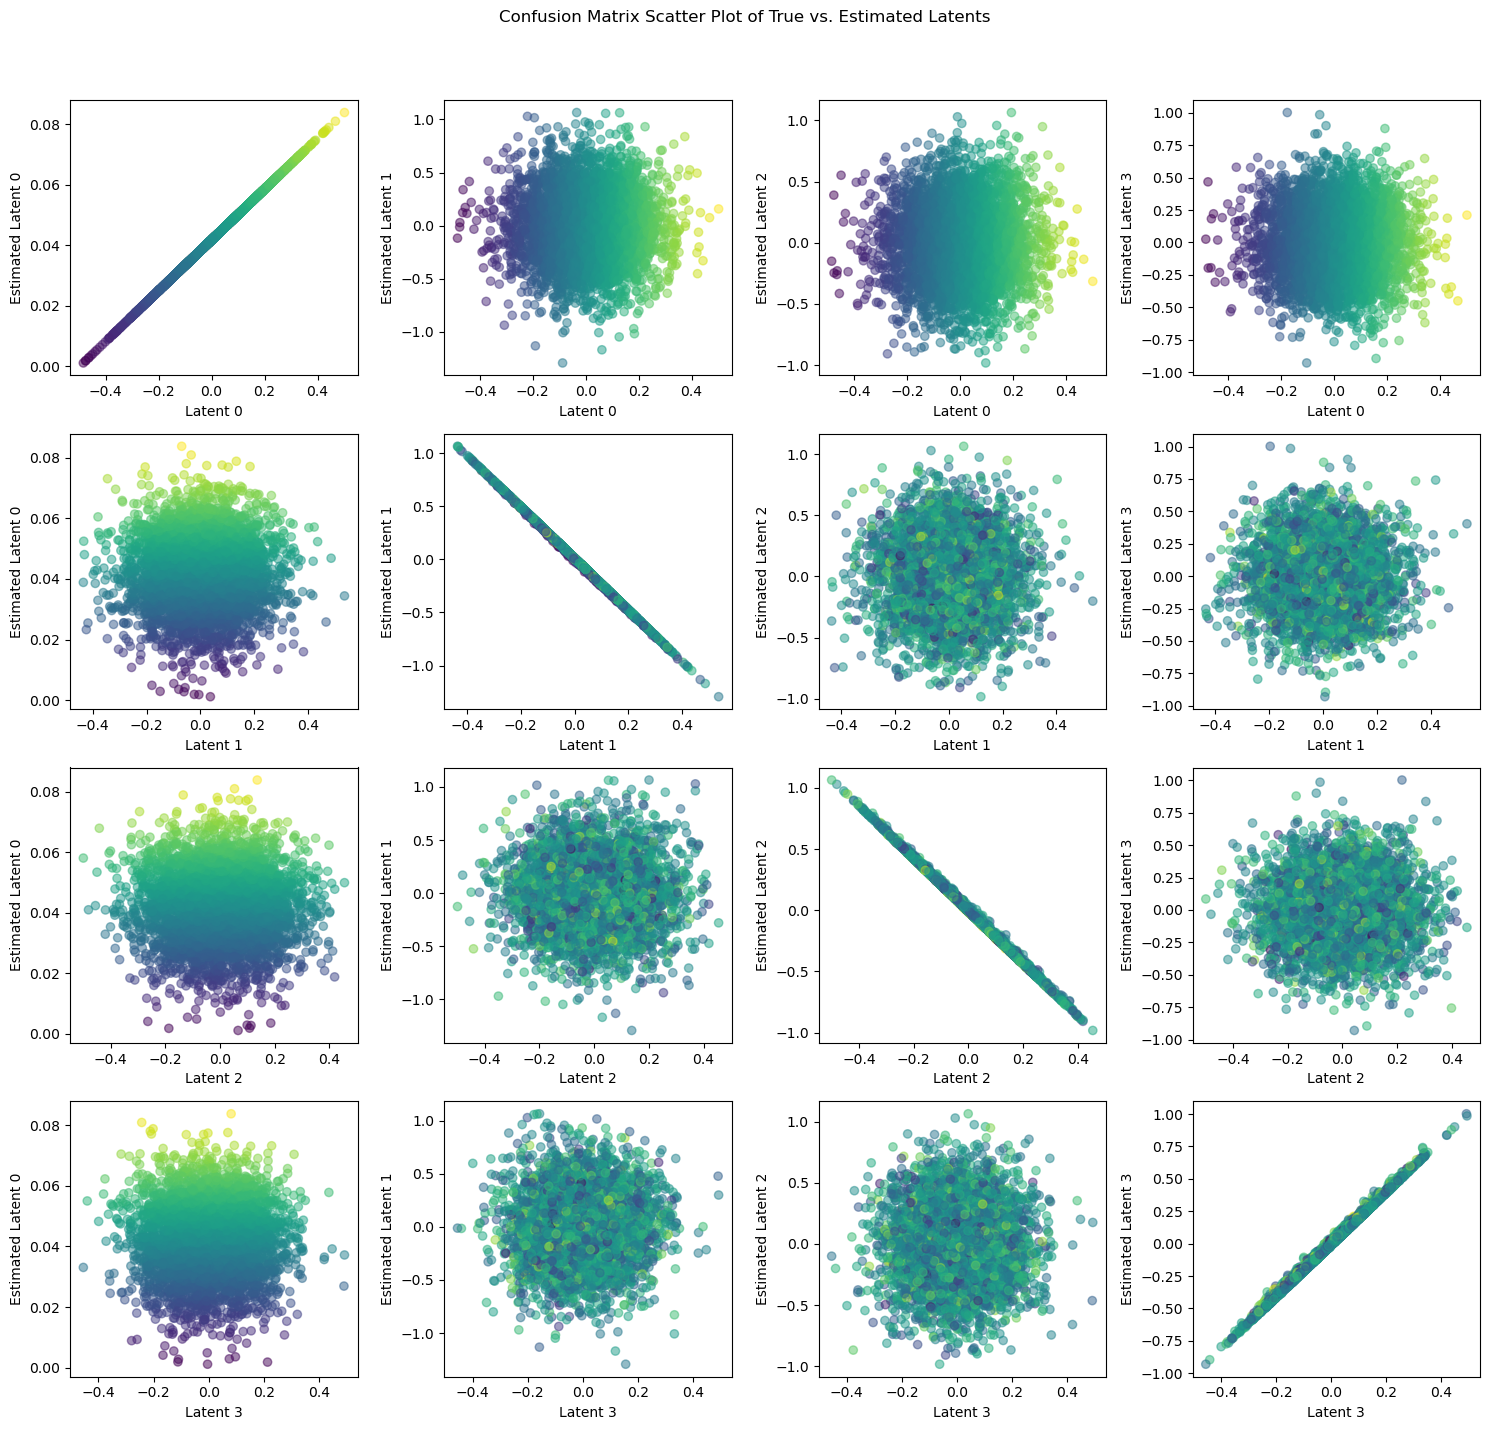

In [36]:
noises_np = noises.detach().numpy()
fig, axes = plt.subplots(nrows=num_latent, ncols=num_latent, figsize=(15, 15))
fig.suptitle('Confusion Matrix Scatter Plot of True vs. Estimated Latents')

for i in range(num_latent):
    for j in range(num_latent):
        ax = axes[i, j]
        ax.scatter(noises_np[:, i], noises_estimates[:, j], alpha=0.5,  c = U_np[:,0])
        ax.set_xlabel(f'Latent {i}')
        ax.set_ylabel(f'Estimated Latent {j}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()